In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# sample source data
somaMeta = pd.read_csv('../data/GNPC_Harmonized_Dataset_V1/SomalogicMetaV1_anonymized.csv')
somaMeta.head()

/tmp/ipykernel_381737/3545570142.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  somaMeta = pd.read_csv('../data/GNPC_Harmonized_Dataset_V1/SomalogicMetaV1_anonymized.csv')


,sample_id,contributor_code,visit,plate_id,units,anml_fraction_used_0_005,anml_fraction_used_0_5,anml_fraction_used_20,anml_fraction_used_20_s1,anml_fraction_used_20_s2,...,hyb_control_norm_scale,norm_scale_0_005,norm_scale_0_5,norm_scale_20,norm_scale_20_s1,norm_scale_20_s2,norm_scale_20_s3,row_check,sample_matrix,sample_type
0,8a0e5419-20f3-44d6-bb46-bab165bf8d05,R,1,147,-1,0.866,0.836,0.847,-1.0,-1.0,...,0.934112,1.435652,0.824065,0.722277,-1.0,-1.0,-1.0,PASS,EDTA Plasma,Sample
1,1f2178f2-83a6-46df-aec1-3dd741621068,R,2,147,-1,0.936,0.947,0.954,-1.0,-1.0,...,0.884058,0.894184,0.804804,0.841661,-1.0,-1.0,-1.0,PASS,EDTA Plasma,Sample
2,40c3925c-a770-4adc-9a87-5d9e2a23b855,R,1,147,-1,0.973,0.939,0.913,-1.0,-1.0,...,0.906697,1.100648,1.043171,0.901319,-1.0,-1.0,-1.0,PASS,EDTA Plasma,Sample
3,9de3c941-b32b-4ef8-8d59-6b57b905c657,R,2,147,-1,0.888,0.843,0.859,-1.0,-1.0,...,0.994137,1.165921,0.942466,0.825704,-1.0,-1.0,-1.0,PASS,EDTA Plasma,Sample
4,03830809-3976-4f58-8279-ca2ffd0398c4,R,2,147,-1,0.850,0.828,0.804,-1.0,-1.0,...,0.925489,1.061411,0.659705,0.608147,-1.0,-1.0,-1.0,PASS,EDTA Plasma,Sample


In [3]:
# sample data files
somaData = {}
indices = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
for i in indices:
    file = f"../data/GNPC_Harmonized_Dataset_V1/Somalogic{i}V1_anonymized.csv"
    try:
        df = pd.read_csv(file, encoding="utf-8", engine="python")
    except:
        df = pd.read_csv(file, encoding="latin1", engine="python")

    somaData[i] = df

In [4]:
# Separate different sample matrices into different dataframes
groups = {key: subdf for key, subdf in somaMeta.groupby("sample_matrix")}


In [5]:
# Extract sample data of a specific matrix type
def get_data_by_matrix_type(matrix_type, groups, somaData):
    if matrix_type not in groups:
        raise ValueError(f"Matrix type {matrix_type} not found in metadata.")
    
    sample_ids = groups[matrix_type]['sample_id'].tolist()
    data_frames = {}
    
    for idx, df in somaData.items():
        filtered_df = df[df['sample_id'].isin(sample_ids)]
        data_frames[idx] = filtered_df
    
    return data_frames


In [6]:
soma_Spec = get_data_by_matrix_type('EDTA Plasma', groups, somaData)

In [7]:
def group_by_missing_values(soma_Spec):
    groups = {}
    for idx, df in soma_Spec.items():
        mask = (df == -1)
        n_missing = mask.sum(axis=1)

        pattern = mask.apply(tuple, axis=1)   # exact missing pattern (True/False per column)

        # For each missing count: True if only 1 pattern, False if multiple
        grouped_patterns = pattern.groupby(n_missing)
        pattern_counts = grouped_patterns.nunique()
        unique_pattern = (pattern_counts == 1).all()
        inconsistent = {}
        if not unique_pattern:
            inconsistent = pattern_counts[pattern_counts != 1].to_dict()
            print(f"Warning: Missing values are scattered among different columns for some missing counts in data file {idx}, further splitting by missing patterns.")
        else:
            print(f"Checked: Missing values exist in consistent columns for each missing count in data file {idx}, showing that missing value is due to different somascan types.")

        # Group by number of missing values
        groups[idx] = {f"missing_{count}": subdf
            for count, subdf in df.groupby(n_missing) if count not in inconsistent
        }
        for count in inconsistent.keys():
            for p_idx, pat in enumerate(grouped_patterns.get_group(count).drop_duplicates()):
                groups[idx][f"missing_{count}_pattern_{p_idx}"] = df[pattern == pat]

    return groups

In [8]:
missing_groups = group_by_missing_values(soma_Spec)
for idx, df in missing_groups.items():
    print(f"DataFrame {idx} grouped by missing values:")
    for missing_count, group in df.items():
        print(f"  Missing values: {missing_count}, Number of samples: {len(group)}")


Checked: Missing values exist in consistent columns for each missing count in data file 01, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 02, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 03, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 04, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 05, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 06, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing c

In [9]:
soma_Spec2 = get_data_by_matrix_type('Serum', groups, somaData)
missing_groups2 = group_by_missing_values(soma_Spec2)
for idx, df in missing_groups2.items():
    print(f"DataFrame {idx} grouped by missing values:")
    for missing_count, group in df.items():
        print(f"  Missing values: {missing_count}, Number of samples: {len(group)}")


Checked: Missing values exist in consistent columns for each missing count in data file 01, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 02, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 03, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 04, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 05, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 06, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing c

In [10]:
soma_Spec3 = get_data_by_matrix_type('CSF', groups, somaData)
missing_groups3 = group_by_missing_values(soma_Spec3)
for idx, df in missing_groups3.items():
    print(f"DataFrame {idx} grouped by missing values:")
    for missing_count, group in df.items():
        print(f"  Missing values: {missing_count}, Number of samples: {len(group)}")


Checked: Missing values exist in consistent columns for each missing count in data file 01, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 02, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 03, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 04, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 05, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 06, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing c

In [11]:
soma_Spec4 = get_data_by_matrix_type('Citrate Plasma', groups, somaData)
missing_groups4 = group_by_missing_values(soma_Spec4)
for idx, df in missing_groups4.items():
    print(f"DataFrame {idx} grouped by missing values:")
    for missing_count, group in df.items():
        print(f"  Missing values: {missing_count}, Number of samples: {len(group)}")


Checked: Missing values exist in consistent columns for each missing count in data file 01, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 02, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 03, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 04, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 05, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing count in data file 06, showing that missing value is due to different somascan types.
Checked: Missing values exist in consistent columns for each missing c

In [13]:
clinicalData = pd.read_csv('../data/GNPC_Harmonized_Dataset_V1/ClinicalV1_anonymized.csv')
clinicalData.head()

,contributor_code,sample_id,sequential_visit_number,age_at_visit,computed_age_range,sex,race,years_of_education,computed_years_education_range,computed_height_range,...,anxiety,cdr,cognitive_test_date,cognitive_test_score,computed_cognitive_test_score,cognitive_test_battery,computed_clinical_diagnosis,computed_cognitive_impairment,is_neuropath,is_biomarker
0,A,2d5cc071-c66c-4a10-b55b-00d6eb03b6f3,1,69,0,1,5,14,0,0,...,0,-1.0,8/25/2021,30,1,MMSE,-1,0,0,0
1,A,26ac68a0-91e9-4d7e-8b58-00e737c3bcd7,1,76,0,1,5,4,2,0,...,0,-1.0,9/23/2022,23,1,MMSE,1,1,0,0
2,A,28f4a373-ba8e-4832-8485-0158dfd8c62b,1,65,0,2,2,14,0,0,...,1,-1.0,1/13/2022,20,1,MMSE,1,1,0,0
3,A,64b27523-4353-420e-b01a-024c470ccf90,1,65,0,2,2,14,0,0,...,0,-1.0,12/10/2021,26,1,MMSE,2,1,0,0
4,A,b68baa17-b013-412d-bf71-0254b6945e8d,1,73,0,2,2,18,0,0,...,0,-1.0,9/28/2021,27,1,MMSE,-1,0,0,0


In [27]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from scipy.stats import gaussian_kde

def plot_histograms(df, columns, bins=40, kde=True, cols_per_row=3):
    """
    Plot publication-quality histograms for any number of DataFrame columns.

    Parameters
    ----------
    df : pandas.DataFrame
        Data containing columns to plot.
    columns : list of str
        Column names to visualize.
    bins : int
        Number of bins for histograms.
    kde : bool
        Whether to overlay KDE curves.
    cols_per_row : int
        How many plots per row in the grid.
    """

    n = len(columns)
    rows = ceil(n / cols_per_row)

    fig, axes = plt.subplots(
        rows, cols_per_row,
        figsize=(6 * cols_per_row, 4.5 * rows),
        dpi=130
    )

    # If only one row, axes may not be 2D
    axes = np.atleast_2d(axes)

    hist_style = dict(
        bins=bins,
        density=True,
        alpha=0.7,
        edgecolor="black",
        linewidth=0.6
    )

    for i, col in enumerate(columns):
        ax = axes[i // cols_per_row][i % cols_per_row]
        data = df[col].dropna()

        # Histogram
        ax.hist(data, **hist_style)

        # KDE
        if kde and len(data) > 1:
            kde_obj = gaussian_kde(data)
            xgrid = np.linspace(data.min(), data.max(), 300)
            ax.plot(xgrid, kde_obj(xgrid), linewidth=2)

        # Titles & labels
        ax.set_title(f"Distribution of {col}", fontsize=14, weight='bold')
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel("Density", fontsize=12)
        ax.grid(alpha=0.3)

        # Clean axes
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=10)

    # Hide any leftover empty axes
    total_axes = rows * cols_per_row
    for j in range(n, total_axes):
        fig.delaxes(axes[j // cols_per_row][j % cols_per_row])

    # plt.tight_layout()
    plt.show()



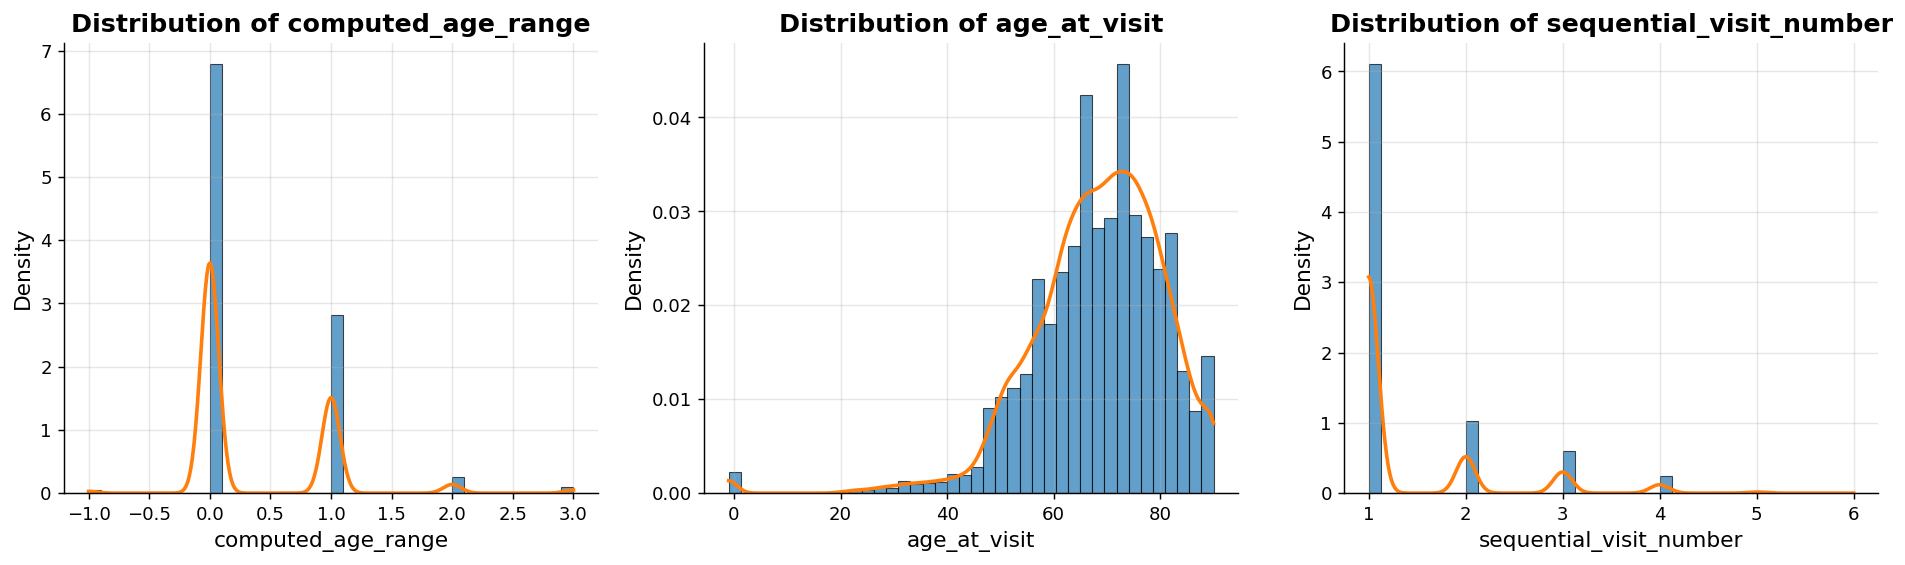

In [37]:
# Age distribution plot
plot_histograms(clinicalData, ['computed_age_range', 'age_at_visit', 'sequential_visit_number'])


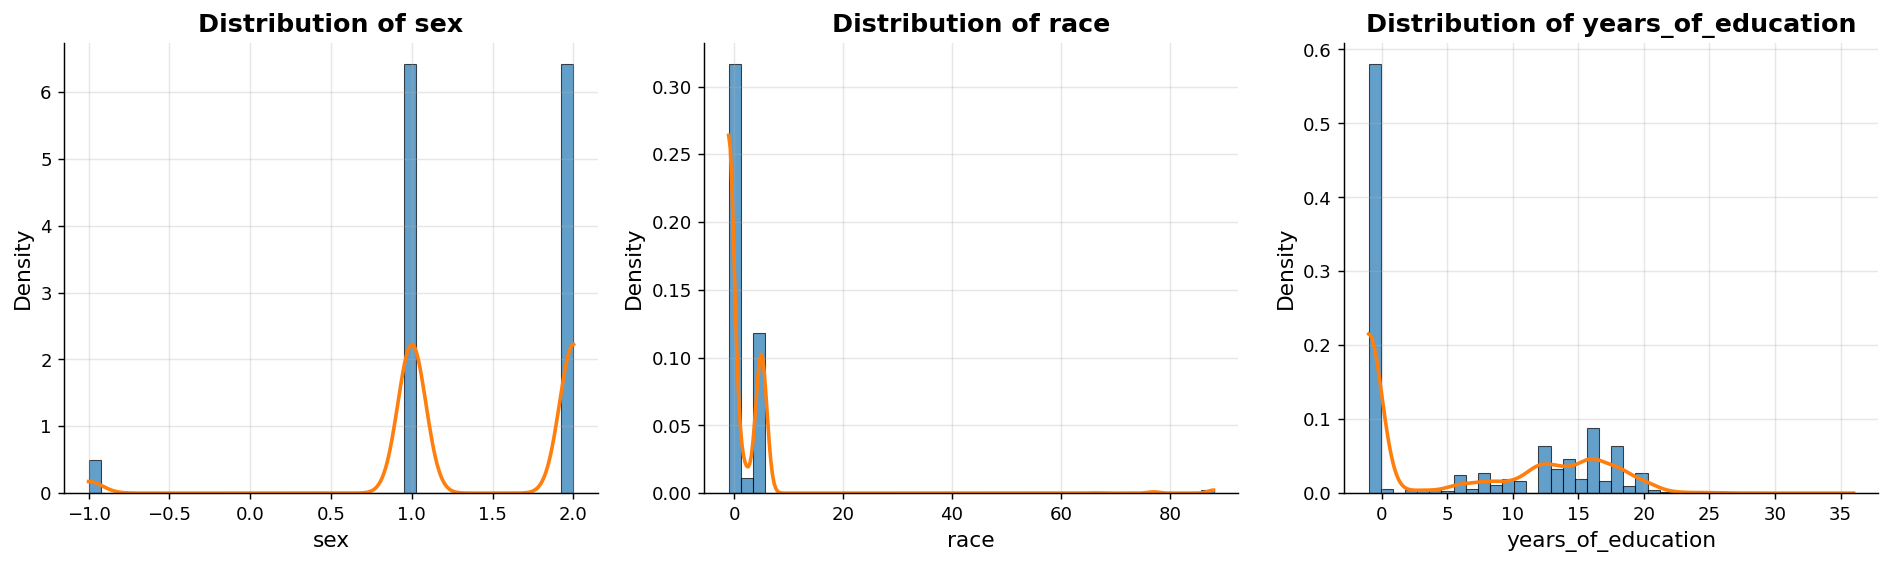

: 

In [ ]:
plot_histograms(clinicalData, ['sex', 'race', 'years_of_education'])


In [14]:
mappingData = pd.read_csv('../data/GNPC_Harmonized_Dataset_V1/PersonMappingV1_anonymized.csv')
mappingData.head()

,person_id,sample_id,is_somalogic,is_mass_spec
0,8aee12c9-962e-48f4-9d15-0008e4443c9d,8aee12c9-962e-48f4-9d15-0008e4443c9d,1,0
1,cd284063-9250-4149-9e8a-0009a615b59d,cd284063-9250-4149-9e8a-0009a615b59d,1,0
2,20fb319a-13a8-4284-83f6-000d1942beb2,20fb319a-13a8-4284-83f6-000d1942beb2,1,0
3,c0493c35-5a4f-4b34-8bdd-000e0c492ae1,c0493c35-5a4f-4b34-8bdd-000e0c492ae1,1,0
4,c0493c35-5a4f-4b34-8bdd-000e0c492ae1,7cdd93db-f393-4a53-a9cb-7cd67ef4b60b,1,0
